In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pywt

from joblib import Parallel, delayed

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
from skimage import draw
from scipy.fftpack import dct

%matplotlib inline




In [2]:
pre_train = pd.read_csv('sign_mnist_train.csv')
pre_test = pd.read_csv('sign_mnist_test.csv')



**TAKE A LOOK**

In [3]:
pre_train.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
#CHECK FOR NULL
print(pre_train.isnull().sum())
print(pre_test.isnull().sum())



label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [5]:
train_set, val_set = train_test_split(pre_train, test_size=0.1, random_state=42)


In [6]:
def process_raw_file_into_dataset_and_label(df_link, hist=False):
    # check filename or DataFrame
    if isinstance(df_link, str):
        df = pd.read_csv(df_link)
    elif isinstance(df_link, pd.DataFrame):
        df = df_link
    else:
        raise ValueError("Input must be a file path or a pandas DataFrame")

    # separate label
    labels = df['label'].values

    #delete label column
    pixels = df.drop(columns=['label']).values
    pixels = pixels.astype(np.float64)

    return pixels, labels


In [7]:
# read data from csv file
X_train, y_train = process_raw_file_into_dataset_and_label(train_set)
X_val, y_val = process_raw_file_into_dataset_and_label(val_set)
X_test, y_test = process_raw_file_into_dataset_and_label(pre_test)

# normalize data from 0 to 1 range
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255



more augmented data for train, take from HOG

In [73]:
augmented_data = np.array(pd.read_csv("augmented_data.csv"))
augmented_labels = np.array(pd.read_csv("augmented_label.csv"))

augmented_labels1 = np.squeeze(augmented_labels)

X_train_DCT_augmented_data = np.vstack((augmented_data, X_train))
y_train_DCT_augmented_data = np.concatenate((augmented_labels1, y_train))

DWT Single

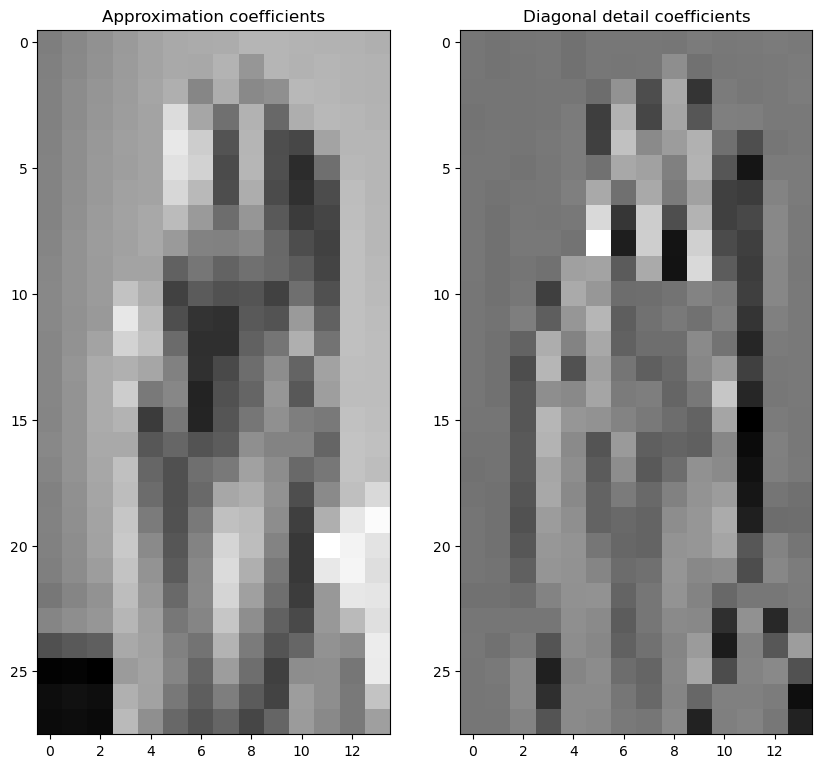

In [8]:
cA, cD = pywt.dwt(X_train[1].reshape(28,28), "haar")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(cA, cmap='gray')
ax[0].set_title("Approximation coefficients")
ax[1].imshow(cD, cmap='gray')
ax[1].set_title("Diagonal detail coefficients")
plt.show()

In [9]:
import numpy as np
import pywt

def single_level_dwt(signal, wavelet_name='haar'):

    cAppro, cDetail = pywt.wavedec(signal, wavelet_name, level=1)
    return cAppro

def single_level_dwt_set(set, wavelet_name='haar'):
    features =[]
    for i in range(len(set)):
        dwt_feature = single_level_dwt(set[i], wavelet_name = wavelet_name)
        dwt_feature = np.array(dwt_feature)
        features.append(dwt_feature)
    return np.array(features)


In [10]:
X_train_DWT_1 = single_level_dwt_set(X_train, wavelet_name='haar')
X_test_DWT_1 = single_level_dwt_set(X_test, wavelet_name='haar')

In [62]:
start = time.time()

# Create an instance of the SVM classifier
model_svm3 = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm3.fit(X_train_DWT_1, y_train)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm3.predict(X_train_DWT_1)
print(classification_report(predictions_train, y_train))

# Make predictions on the test data and print the classification report
predictions_test = model_svm3.predict(X_test_DWT_1)
print(classification_report(predictions_test, y_test))


Fit time: 38.62326264381409
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1027
           1       1.00      1.00      1.00       912
           2       1.00      1.00      1.00      1026
           3       1.00      1.00      1.00      1070
           4       1.00      1.00      1.00       872
           5       1.00      1.00      1.00      1069
           6       1.00      1.00      1.00       967
           7       1.00      1.00      1.00       916
           8       1.00      1.00      1.00      1058
          10       1.00      1.00      1.00      1006
          11       1.00      1.00      1.00      1109
          12       1.00      1.00      1.00       931
          13       1.00      1.00      1.00      1056
          14       1.00      1.00      1.00      1091
          15       1.00      1.00      1.00       968
          16       1.00      1.00      1.00      1142
          17       1.00      1.00      1.00      1159

In [75]:
X_train_DWT_1_augment = single_level_dwt_set(X_train_DCT_augmented_data, wavelet_name='haar')
X_test_DWT_1_augment = single_level_dwt_set(X_test, wavelet_name='haar')

In [79]:
start = time.time()

# Create an instance of the SVM classifier
model_svm3 = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm3.fit(X_train_DWT_1_augment, y_train_DCT_augmented_data)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm3.predict(X_train_DWT_1_augment)
print(classification_report(predictions_train, y_train_DCT_augmented_data))

# Make predictions on the test data and print the classification report
predictions_test = model_svm3.predict(X_test_DWT_1_augment)
print(classification_report(predictions_test, y_test))


Fit time: 225.95644760131836
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1804
         1.0       0.99      0.98      0.99      1635
         2.0       0.99      1.00      0.99      1804
         3.0       0.93      0.96      0.94      1846
         4.0       0.97      0.98      0.97      1515
         5.0       0.98      0.99      0.98      1895
         6.0       0.97      0.98      0.98      1708
         7.0       0.98      0.98      0.98      1616
         8.0       0.97      0.95      0.96      1902
        10.0       0.95      0.96      0.96      1767
        11.0       0.98      0.98      0.98      1987
        12.0       0.93      0.97      0.95      1611
        13.0       0.97      0.94      0.95      1905
        14.0       0.99      0.98      0.99      1949
        15.0       1.00      1.00      1.00      1729
        16.0       0.99      1.00      1.00      2032
        17.0       0.92      0.90      0.91      210

1st DWT flatten image losing the spatial structure of the image, can not detect rotate image
2nd we add more training data

DWT 2 level - DCT hybrid 

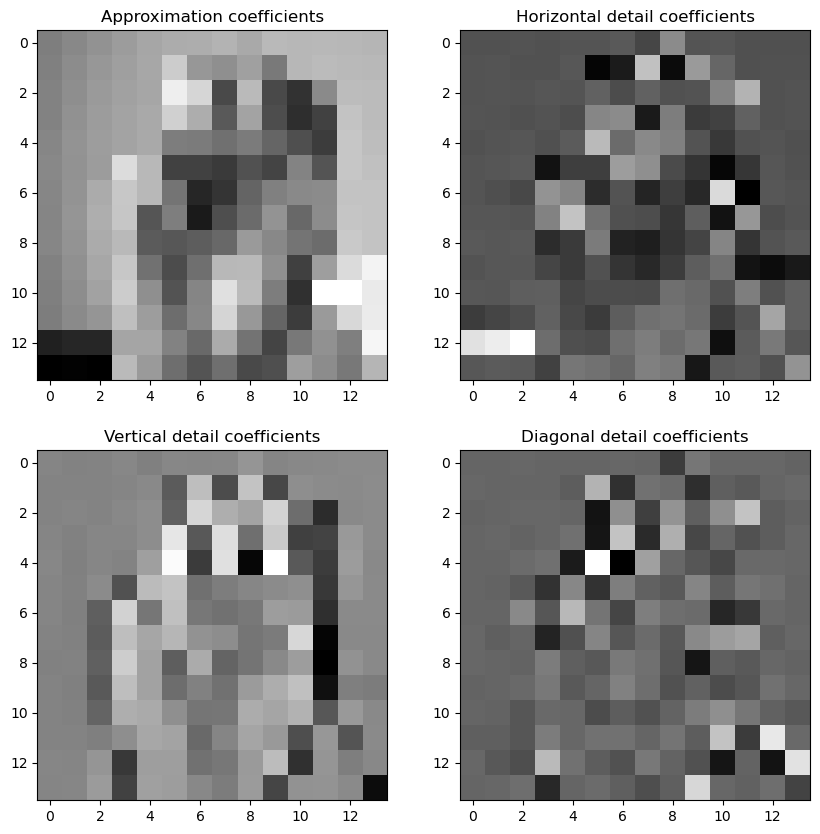

In [14]:
cA, (cH, cV, cD) = pywt.dwt2(X_train[1].reshape(28,28), "haar")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0, 0].imshow(cA, cmap='gray')
ax[0, 0].set_title("Approximation coefficients")
ax[0, 1].imshow(cH, cmap='gray')
ax[0, 1].set_title("Horizontal detail coefficients")
ax[1, 0].imshow(cV, cmap='gray')
ax[1, 0].set_title("Vertical detail coefficients")
ax[1, 1].imshow(cD, cmap='gray')
ax[1, 1].set_title("Diagonal detail coefficients")
plt.show()

In [150]:
def apply_dwt2(image):
    # Ensure the image is in the correct shape
    image = image.reshape(28, 28)
    
    # Perform 2D discrete wavelet transform
    cA, (cH, cV, cD) = pywt.dwt2(image, 'haar')
    
    return cA, cH, cV, cD

def extract_dwt2_features(image):
    # Apply DWT
    cA, cH, cV, cD = apply_dwt2(image)
    
    # Flatten the coefficients
    cA_flat = cA.flatten()
    cH_flat = cH.flatten()
    cV_flat = cV.flatten()
    cD_flat = cD.flatten()
    
    # Concatenate the coefficients to form the feature vector
    feature_vector = np.concatenate((cA_flat, cH_flat, cV_flat, cD_flat))
    
    return feature_vector

In [151]:
print(extract_dwt2_features(X_train[1]))

[ 9.13725490e-01  9.60784314e-01  1.00588235e+00  1.05098039e+00
  1.09411765e+00  1.12549020e+00  1.12745098e+00  1.16078431e+00
  1.10784314e+00  1.18431373e+00  1.17450980e+00  1.17843137e+00
  1.17450980e+00  1.16274510e+00  9.23529412e-01  9.76470588e-01
  1.02745098e+00  1.06274510e+00  1.10196078e+00  1.26862745e+00
  1.02941176e+00  9.92156863e-01  1.06862745e+00  8.94117647e-01
  1.17450980e+00  1.19411765e+00  1.18431373e+00  1.17647059e+00
  9.31372549e-01  9.88235294e-01  1.04117647e+00  1.07254902e+00
  1.09411765e+00  1.42549020e+00  1.31764706e+00  6.70588235e-01
  1.18823529e+00  6.68627451e-01  5.64705882e-01  9.66666667e-01
  1.19607843e+00  1.19019608e+00  9.33333333e-01  9.98039216e-01
  1.04901961e+00  1.08823529e+00  1.11176471e+00  1.28627451e+00
  1.12745098e+00  7.41176471e-01  1.08823529e+00  6.86274510e-01
  5.45098039e-01  6.37254902e-01  1.22745098e+00  1.19411765e+00
  9.49019608e-01  1.00784314e+00  1.05686275e+00  1.08823529e+00
  1.11176471e+00  9.07843

In [152]:
X_train_dwt2 = Parallel(n_jobs=-1)(delayed(extract_dwt2_features)(image) for image in X_train)
X_test_dwt2 = Parallel(n_jobs=-1)(delayed(extract_dwt2_features)(image) for image in X_test)


In [153]:
start = time.time()

# Create an instance of the SVM classifier
model_svm3 = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm3.fit(X_train_dwt2, y_train)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm3.predict(X_train_dwt2)
print(classification_report(predictions_train, y_train, zero_division=1))

# Make predictions on the test data and print the classification report
predictions_test = model_svm3.predict(X_test_dwt2)
print(classification_report(predictions_test, y_test, zero_division=1))


Fit time: 161.80808305740356
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1028
           1       1.00      0.99      0.99       925
           2       1.00      1.00      1.00      1026
           3       0.94      0.95      0.95      1054
           4       1.00      1.00      1.00       870
           5       0.92      1.00      0.96       980
           6       0.96      0.97      0.97       953
           7       0.95      1.00      0.97       869
           8       0.94      0.94      0.94      1055
          10       0.87      0.89      0.88       985
          11       0.97      0.96      0.96      1126
          12       0.90      0.99      0.94       845
          13       0.97      0.93      0.95      1107
          14       1.00      1.00      1.00      1088
          15       1.00      0.99      0.99       978
          16       1.00      0.99      1.00      1149
          17       0.86      0.78      0.82      128